In [1]:
! pip install -q pyforest
! pip install -q  text_hammer
# ! pip install -q transformers`

     |████████████████████████████████| 115 kB 15.0 MB/s 
/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [4]:
! pip install -q transformers

     |████████████████████████████████| 5.3 MB 15.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
     |████████████████████████████████| 163 kB 77.8 MB/s 


In [ ]:
from google.colab import files

files.upload()

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import text_hammer as th

from sklearn.model_selection import train_test_split
from tensorflow.data import AUTOTUNE
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, \
                         AutoConfig

import os
import csv
import re

## Data Preprocessing

In [6]:
pwd = os.getcwd()

TEST_PATH = pwd + "/new_train.csv"

TEST_SIZE = 0.2

In [7]:
def parse_data(filepath):

    with open(filepath, encoding="utf8") as file:

        tweets = []
        labels = []

        csv_reader = csv.reader(file)

        next(csv_reader)

        for row in csv_reader:

            tweet = row[0]
            label = row[1]

            tweets.append(tweet)
            labels.append(label)

    return tweets, labels


TWEETS, LABELS = parse_data(TEST_PATH)

In [10]:
def clean_data(ori_tweets):

    tweets = []

    for tweet in ori_tweets:
        tweet = str(tweet).lower().replace('\\', '').replace('_', ' ')
        tweet = th.cont_exp(tweet)
        tweet = th.remove_emails(tweet)
        tweet = re.sub(r'[^\w]', ' ', tweet)
        tweet = th.remove_rt(tweet)
        tweet = th.remove_accented_chars(tweet)
        tweet = th.remove_special_chars(tweet)
        tweet = re.sub("(.)\\1{2,}", "\\1", tweet)

        tweets.append(tweet)

    # tweets = np.array(tweets).reshape(-1, 1)

    return tweets

TWEETS = clean_data(TWEETS)
LABELS = np.array(LABELS).astype("float32")

In [12]:
def split_data(tweets, labels, test_size):

    train_tweets, val_tweets, train_labels, val_labels = train_test_split(tweets, labels, test_size=test_size,
                                                                          random_state=42)

    return train_tweets, val_tweets, train_labels, val_labels


TRAIN_TWEETS, VAL_TWEETS, TRAIN_LABELS, VAL_LABELS = split_data(TWEETS, LABELS, TEST_SIZE)

In [51]:
@tf.function
def f1_score(y, yhat, thresh=0.5):

    y_pred = tf.cast(tf.greater(yhat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    score = tf.reduce_mean(f1)

    return score

## Model Building and Training

In [15]:
model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [44]:
batch_size = 32
num_labels = 2

id2label = {0: "not disaster",
            1: "disaster"}

label2id = {val: key for key, val in id2label.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels,
                                                             id2label=id2label, label2id=label2id)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [17]:
max_length = max([len(x.split()) for x in TWEETS])
max_length

35

In [20]:
TRAIN_TWEETS_ENCODINGS = tokenizer(
    text=TRAIN_TWEETS,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

VAL_TWEETS_ENCODINGS = tokenizer(
    text=VAL_TWEETS,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(TRAIN_TWEETS_ENCODINGS), TRAIN_LABELS)).batch(batch_size).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((dict(VAL_TWEETS_ENCODINGS), VAL_LABELS)).batch(batch_size).prefetch(AUTOTUNE)

In [28]:
train_dataset

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 35), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [46]:
model.summary()


Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [48]:
from transformers import create_optimizer

In [58]:
! pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 14.5 MB/s 
     |████████████████████████████████| 1.3 MB 66.0 MB/s 
     |████████████████████████████████| 352 kB 77.7 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 238 kB 8.0 MB/s 
     |████████████████████████████████| 5.9 MB 52.6 MB/s 
     |████████████████████████████████| 118 kB 76.2 MB/s 
     |████████████████████████████████| 1.1 MB 62.7 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 4.6 MB 56.3 MB/s 


In [59]:
from official.nlp import optimization

In [61]:
epochs=5

batches_per_epoch = len(train_dataset) // batch_size
total_train_steps = int(batches_per_epoch * epochs)
optimizer = optimization.create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps, optimizer_type="adamw")

In [64]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
191/191 [==============================] - 39s 157ms/step - loss: 0.6222 - accuracy: 0.7215 - val_loss: 0.6076 - val_accuracy: 0.7656
Epoch 2/5
191/191 [==============================] - 28s 149ms/step - loss: 0.6171 - accuracy: 0.7269 - val_loss: 0.6076 - val_accuracy: 0.7656
Epoch 3/5
191/191 [==============================] - 28s 148ms/step - loss: 0.6163 - accuracy: 0.7264 - val_loss: 0.6076 - val_accuracy: 0.7656
Epoch 4/5
191/191 [==============================] - 28s 148ms/step - loss: 0.6167 - accuracy: 0.7284 - val_loss: 0.6076 - val_accuracy: 0.7656
Epoch 5/5
191/191 [==============================] - 28s 148ms/step - loss: 0.6165 - accuracy: 0.7327 - val_loss: 0.6076 - val_accuracy: 0.7656


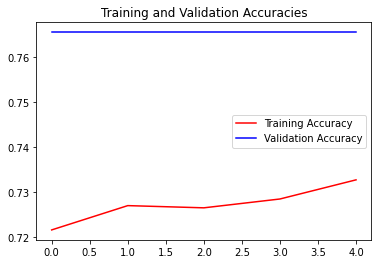

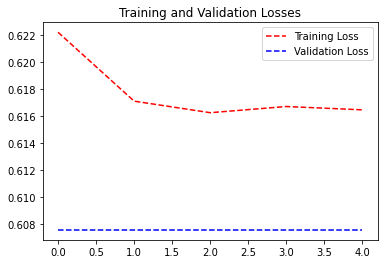

In [80]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "red", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "red", ls="--", label="Training Loss")
plt.plot(epochs, val_loss, "blue", ls="--", label="Validation Loss")
plt.title("Training and Validation Losses")
plt.legend()

plt.show()

## Make Predictions

In [66]:
TEST_PATH = pwd + "/test.csv"
SAMPLE_PATH = pwd + "/sample_submission.csv"

In [67]:
def parse_test_data(filepath):

    with open(filepath, encoding="utf8") as file:

        tweets = []

        csv_reader = csv.reader(file)

        next(csv_reader)

        for row in csv_reader:

            tweet = row[-1]

            tweets.append(tweet)

    return tweets

In [68]:
TEST_TWEETS = parse_test_data(TEST_PATH)
TEST_TWEETS = clean_data(TEST_TWEETS)

sample_submission = pd.read_csv(SAMPLE_PATH)

In [75]:
TEST_TWEETS_ENCODINGS = tokenizer(
    text=TEST_TWEETS,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True,
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [76]:
test_dataset = tf.data.Dataset.from_tensor_slices((dict(TEST_TWEETS_ENCODINGS))).batch(batch_size).prefetch(AUTOTUNE)

In [79]:
predictions = model.predict(test_dataset)

predictions = np.argmax(predictions.logits, axis = -1)

sample_submission["target"] = predictions

sample_submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 4s 43ms/step


In [81]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>